In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Tue Nov 13 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [44]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-44-a857d1235d28>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [202]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [41]:
def prepare_dfs(col='lyap'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, 'training_raw.pickle'))
    df = df.loc[:, (slice(None), col)].dropna()
    df.columns = df.columns.droplevel(1)
    df = df.astype(float)
    
    df_y = pd.read_pickle(os.path.join(LABELED_ROOT, 'labels.pickle'))
    df = df.join(df_y)
    
    extra = pd.DataFrame(index=df.index, columns=EXTRA)
    for name, row in extra.iterrows():
        extra.loc[name, 'age'] = meta_df.loc[int(name[0]), 'AGE']
        extra.loc[name, 'sex'] = meta_df.loc[int(name[0]), 'SEX']
        m1 = meta_df.loc[int(name[0]), 'M_1']
        m4 = meta_df.loc[int(name[0]), 'M_4']
        extra.loc[name, 'sc_bef'] = m1
        extra.loc[name, 'sc_aft'] = m4
        extra.loc[name, 'change'] = m1 / m4
    df = df.join(extra)
    
    df_bef = df.loc[(slice(None), 'a'), :]
    df_bef.index = df_bef.index.droplevel(1)
    df_aft = df.loc[(slice(None), 'b'), :]
    df_aft.index = df_aft.index.droplevel(1)
    
    in_both = df_bef.join(df_aft, how='inner', lsuffix='_l').index
    df = df.loc[(in_both, slice(None)), :]
    df_bef = df_bef.loc[in_both, :]
    df_aft = df_aft.loc[in_both, :]
     
    return df, df_bef, df_aft
df, df_bef, df_aft = prepare_dfs()

In [4]:
print('Men / Women: {} / {}'.format(len(df[df['sex']==1]), len(df[df['sex']==0])))
age_desc = df['age'].describe()
print('Age summary: \n{}'.format(age_desc))
m1_desc = df['sc_bef'].describe()
print('Measurement 1: \n{}'.format(m1_desc))
m2_desc = df['sc_aft'].describe()
print('Measurement 2: \n{}'.format(m2_desc))

Men / Women: 52 / 168
Age summary: 
count    220.000000
mean      48.063636
std        9.798217
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: age, dtype: float64
Measurement 1: 
count    220.000000
mean      27.654545
std        4.276807
min       17.000000
25%       25.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: sc_bef, dtype: float64
Measurement 2: 
count    220.000000
mean      16.972727
std        7.850730
min        2.000000
25%       11.000000
50%       17.000000
75%       23.000000
max       37.000000
Name: sc_aft, dtype: float64


# Before and after comparison plots

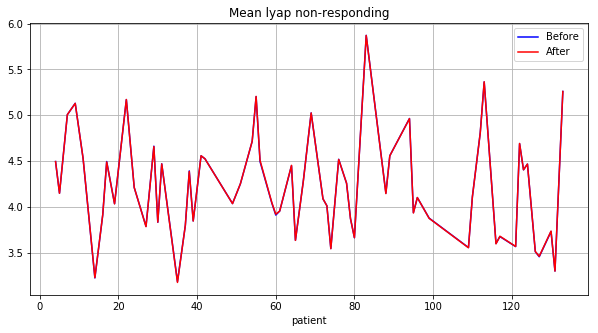

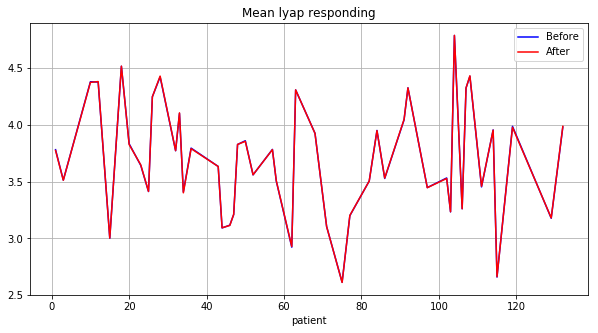

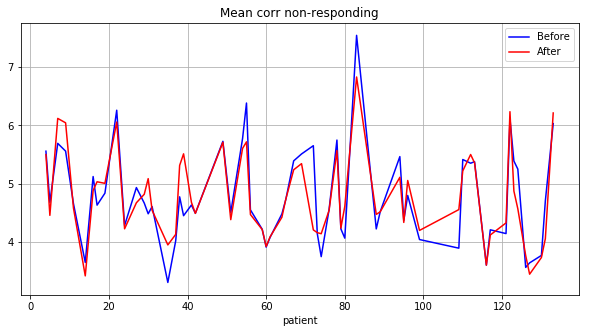

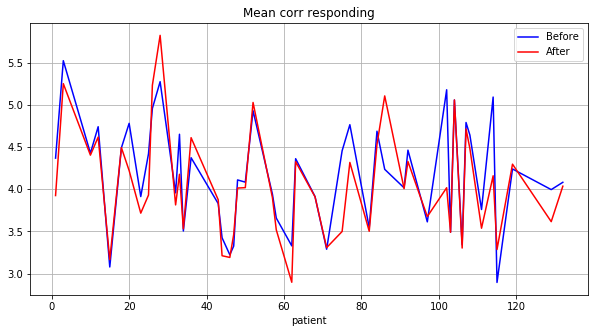

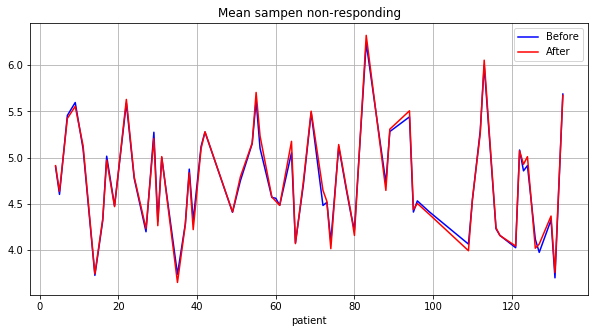

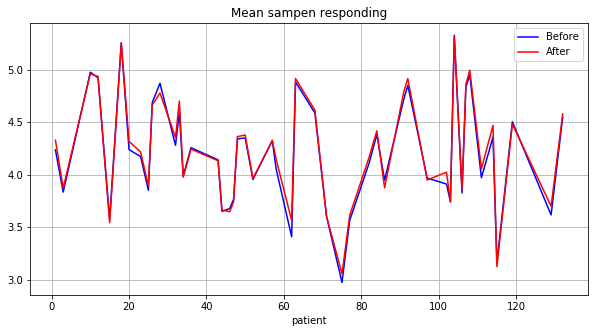

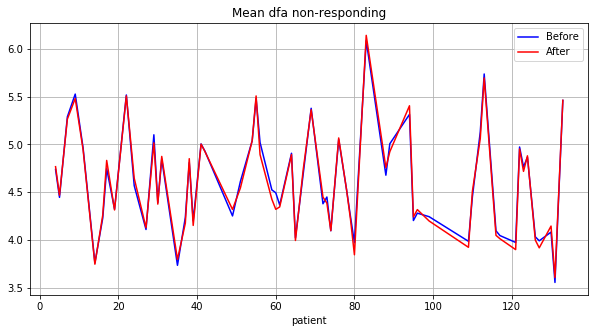

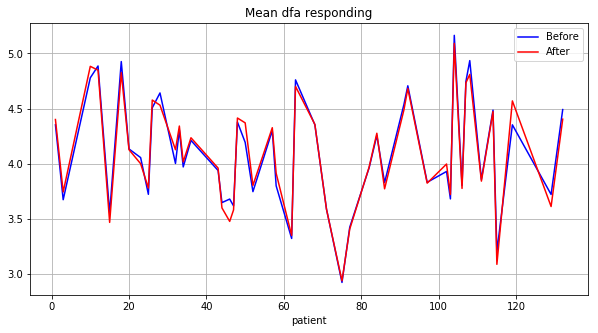

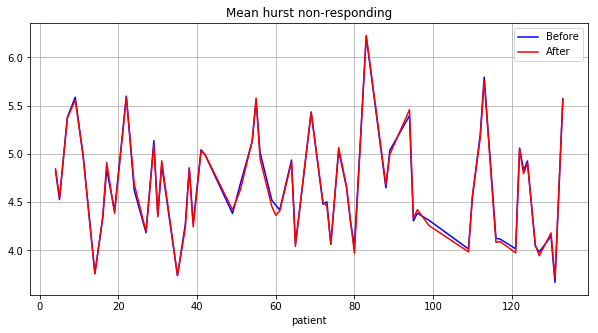

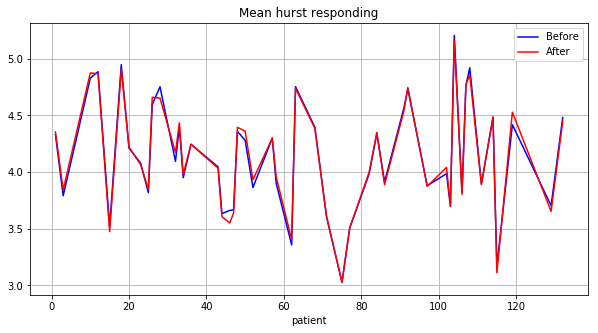

In [5]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    plot_measure(df_bef, df_aft, col)

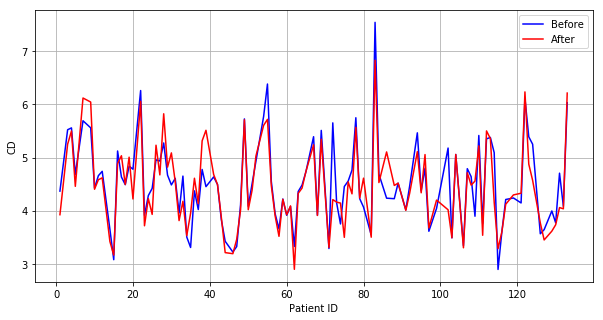

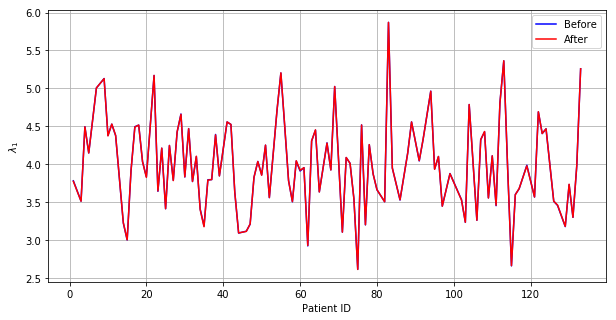

In [6]:
def plot_resp(df_bef, df_aft, m_name):
    means_bef = df_bef.mean(axis=1)
    means_aft = df_aft.mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    # plt.title(f'Mean {m_name} all')
    plt.xlabel('Patient ID')
    plt.ylabel(f'{m_name}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name)

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
#     df, df_bef, df_aft = prepare_dfs(col)
#     plot_measure(df_bef, df_aft, col)
df, df_bef, df_aft = prepare_dfs('corr')
plot_measure(df_bef, df_aft, 'CD')
df, df_bef, df_aft = prepare_dfs('lyap')
plot_measure(df_bef, df_aft, '$\lambda_1$')

# Before and after K-S test

In [7]:
from scipy.stats import ks_2samp

def print_res(name, res):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {}'.format(name, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef.mean(axis=1), df_aft.mean(axis=1)))
    print_res('Stds', ks_2samp(df_bef.std(axis=1), df_aft.std(axis=1)))
    for col in df.loc[:, map(lambda c: not c.startswith('label'), df.columns)].columns:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]))
        

for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE***')
for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['label_d']=='L']
    high = df[df['label_d']=='H']
    channel_wise_ks(low, high)
    print()

LYAP
All
Means: 	 1.0000000000000004 	 
Stds: 	 0.9999999999999991 	 
FP1: 	 0.8398565398006287 	 
FP2: 	 0.8398565398006287 	 
F3: 	 0.5060304054051364 	 
F4: 	 0.6185828173807614 	 
C3: 	 0.9236520520256825 	 
C4: 	 0.7336458901692725 	 
P3: 	 0.09437420582631731 	 
P4: 	 0.9236520520256825 	 
O1: 	 0.3141209045295976 	 
O2: 	 0.1312293712733436 	 
F7: 	 0.8398565398006284 	 
F8: 	 0.1312293712733436 	 
T3: 	 0.17902368629316182 	 
T4: 	 0.6185828173807629 	 
T5: 	 0.9236520520256825 	 
T6: 	 0.5060304054051377 	 
Fz: 	 0.9236520520256825 	 
Cz: 	 0.8398565398006287 	 
Pz: 	 0.9750577553253458 	 
age: 	 1.0 	 
sex: 	 1.0 	 
sc_bef: 	 1.0 	 
sc_aft: 	 1.0 	 
change: 	 1.0 	 

Non-responding
Means: 	 0.999999999999998 	 
Stds: 	 1.0000000000000004 	 
FP1: 	 0.9204465881690447 	 
FP2: 	 0.800634955895231 	 
F3: 	 0.9838897798760781 	 
F4: 	 0.6499999547888378 	 
C3: 	 0.9204465881690451 	 
C4: 	 0.8006349558952316 	 
P3: 	 0.04414095739429716 	 !!
P4: 	 0.9204465881690451 	 
O1: 	 0.498

HURST
All
Means: 	 0.9999992854044397 	 
Stds: 	 1.0000000000000004 	 
FP1: 	 0.9957738525263734 	 
FP2: 	 0.40331693180924505 	 
F3: 	 0.5060304054051364 	 
F4: 	 0.9236520520256825 	 
C3: 	 0.1312293712733436 	 
C4: 	 0.7336458901692725 	 
P3: 	 0.6185828173807629 	 
P4: 	 0.40331693180924505 	 
O1: 	 0.9957738525263734 	 
O2: 	 0.40331693180924505 	 
F7: 	 0.9236520520256825 	 
F8: 	 0.8398565398006282 	 
T3: 	 0.3141209045295979 	 
T4: 	 0.5060304054051371 	 
T5: 	 0.8398565398006286 	 
T6: 	 0.6185828173807629 	 
Fz: 	 0.9236520520256825 	 
Cz: 	 0.31412090452959734 	 
Pz: 	 0.4033169318092446 	 
age: 	 1.0 	 
sex: 	 1.0 	 
sc_bef: 	 1.0 	 
sc_aft: 	 1.0 	 
change: 	 1.0 	 

Non-responding
Means: 	 0.9999991429292808 	 
Stds: 	 0.9999999999999984 	 
FP1: 	 0.9992388504277651 	 
FP2: 	 0.2567119167536623 	 
F3: 	 0.4985266872758723 	 
F4: 	 0.9204465881690447 	 
C3: 	 0.1740946368686929 	 
C4: 	 0.9204465881690447 	 
P3: 	 0.6499999547888379 	 
P4: 	 0.2567119167536629 	 
O1: 	 0.9

# PCA

No handles with labels found to put in legend.


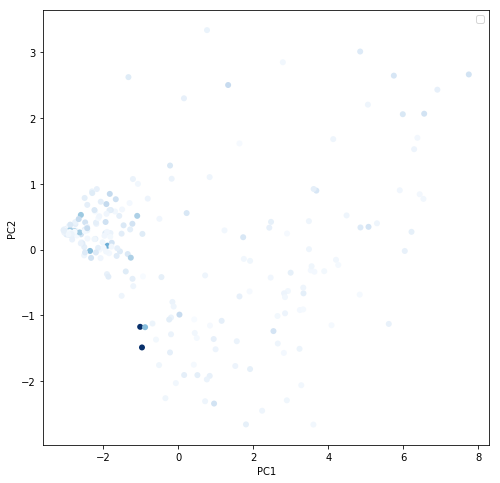

No handles with labels found to put in legend.


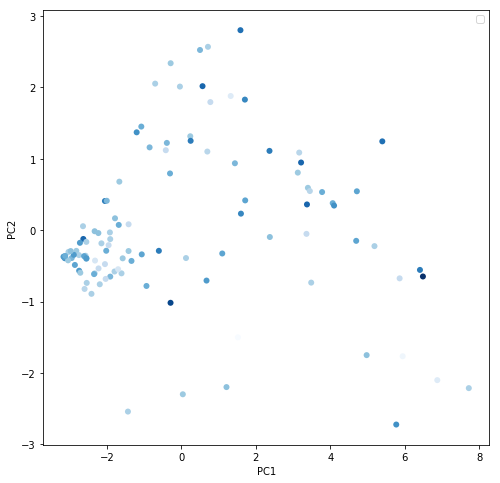

No handles with labels found to put in legend.


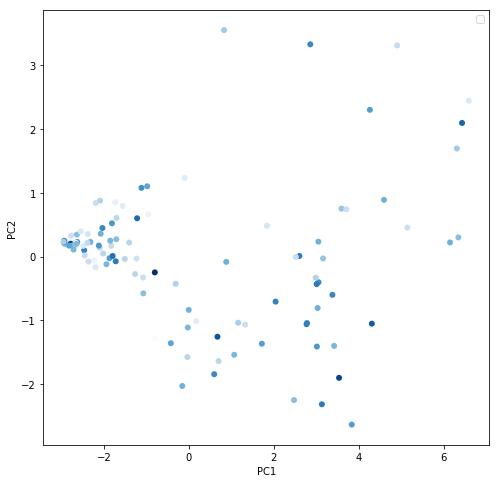

No handles with labels found to put in legend.


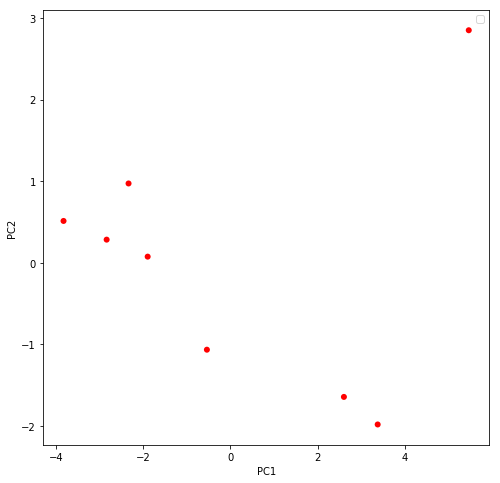

No handles with labels found to put in legend.


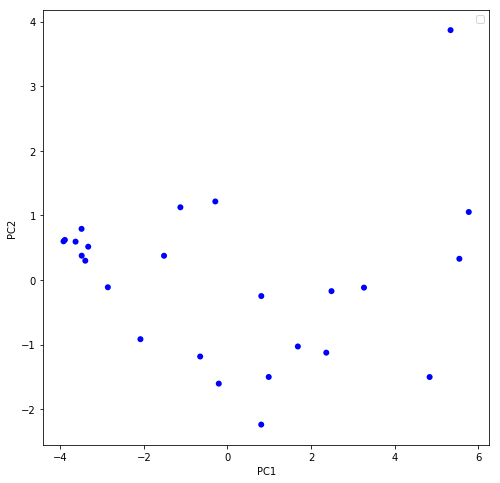

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second=None, c1='blue', c2='red', title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

df, df_bef, df_aft = prepare_dfs('corr')

# plot_pca_2d(df_bef, df_aft, title="Before / After")
plot_pca_2d(df, None, c1=df['change'], title="Change in score")
plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="")
plot_pca_2d(df_aft, None, c1=df_aft['sc_aft'], title="")
plot_pca_2d(df_aft[df_aft['sc_aft'] > 27], c1='red', title="")
plot_pca_2d(df_bef[df_bef['sc_bef'] > 30], title="")

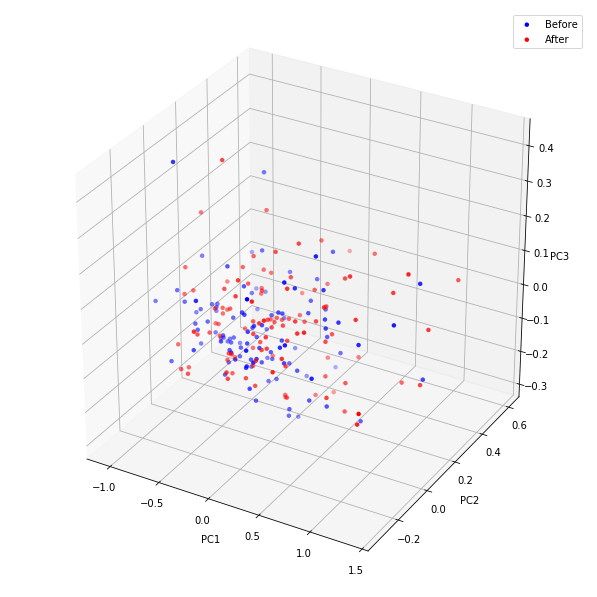

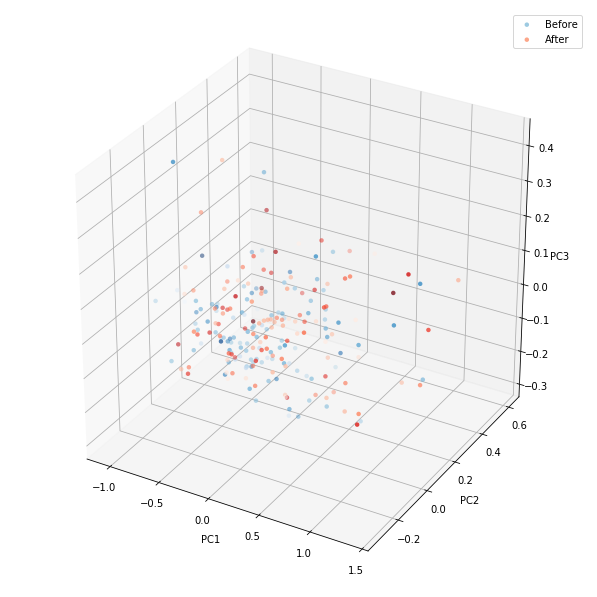

In [38]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('sampen')

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")

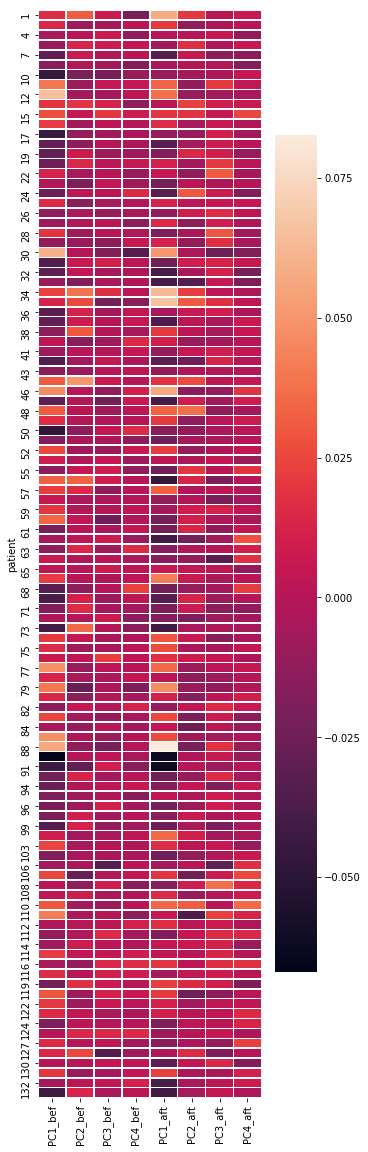

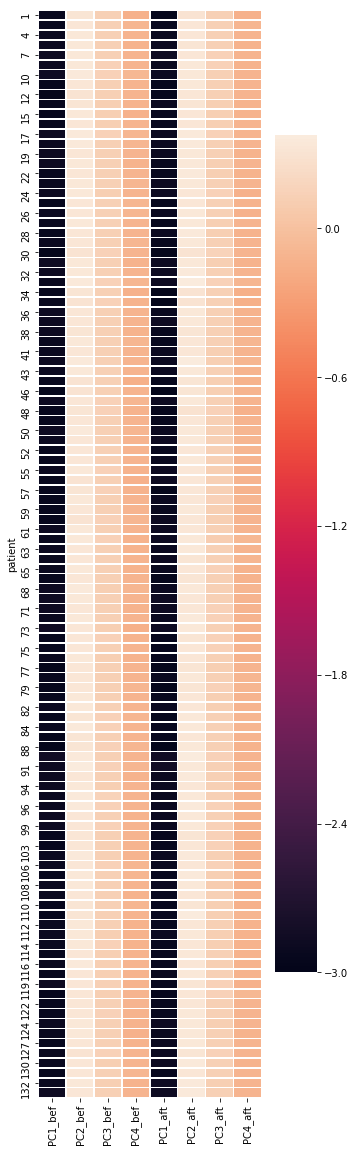

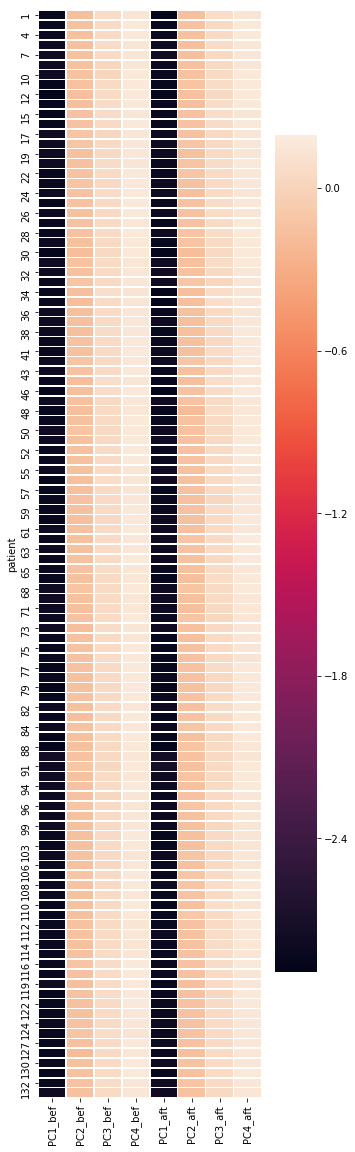

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

for measure in ('lyap', 'corr', 'sampen'):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

No handles with labels found to put in legend.


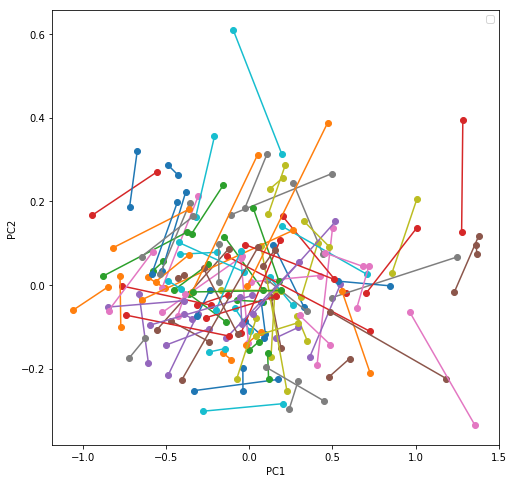

In [33]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    for i in range(len(first)):
        xs = [first[i, 0], second[i, 0]]
        ys = [first[i, 1], second[i, 1]]
        plt.plot(xs, ys, 'o-')
        
    plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('sampen')

plot_pca_pairs_2d(df_bef, df_aft, title="")

In [43]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['label_r', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

df, df_bef, df_aft = prepare_dfs('sampen')

filter_by_distance(df_bef, df_aft)

     label_r   age  sex  sc_bef  sc_aft    change
33       1.0  62.0  0.0    25.0     7.0  3.571429
56       0.0  48.0  0.0    31.0    27.0  1.148148
58       1.0  41.0  0.0    28.0    12.0  2.333333
62       1.0  34.0  0.0    23.0    10.0  2.300000
64       0.0  53.0  0.0    26.0    26.0  1.000000
72       0.0  55.0  0.0    23.0    18.0  1.277778
102      1.0  56.0  1.0    18.0     6.0  3.000000
111      1.0  42.0  0.0    29.0     4.0  7.250000
114      1.0  55.0  0.0    25.0    12.0  2.083333
126      0.0  40.0  0.0    25.0    17.0  1.470588
127      0.0  35.0  0.0    25.0    21.0  1.190476
